# 3D Multi-organ Segmentation with MEDICAI¶
This tutorials shows how to use [`medicai`](https://github.com/innat/medic-ai), a [keras](https://keras.io/) based multi-backend medical image processing library to solve multi organ 3D segmentation task. It contains the following features:

- Load `tfrecod` with image, label and affine information and build with `tf.data` API.
- Define `medicai` medical image transformation API.
- Define 3D segmentation model from `medicai`, i.e. SwinUNETR.
- Define dice loss and metrics from `medicai`.
- Evaluation per-class metric score after training.
- Visualize model predictions.

---

## Dataset

The original data source can be found in [synapse.org](https://www.synapse.org/Synapse:syn3193805/wiki/217752). The `.nii` format Multi organ scans can be found [here](https://www.kaggle.com/datasets/lssz1275/abdomen). We have converted the raw format to `tfrecord` format. The format process can be found [here](https://www.kaggle.com/datasets/ipythonx/abdomen). The converted `tfrecord` dataset can be found [here](https://www.kaggle.com/code/ipythonx/abdomen-nii-to-tfrecord/notebook). Each `tfrecord` file contains max 10 file in each. 

[**Imaging Data Description:**](https://www.synapse.org/Synapse:syn3193805/wiki/89480) The BTCV abdomen challenge dataset contains CT scans from `30` people. In this dataset, `13` abdominal organs are labeled by experts under the supervision of radiologists from Vanderbilt University Medical Center. The task is to segment these `13` organs, which include large ones like the **liver**, **spleen**, **kidneys**, and **stomach**; blood vessels such as the **esophagus**, **aorta**, **inferior vena cava**, **splenic vein**, and **portal vein**; and smaller organs like the **gallbladder**, **pancreas**, and **adrenal glands**. Of the `30` scans, `24` are used for training and `6` for testing.

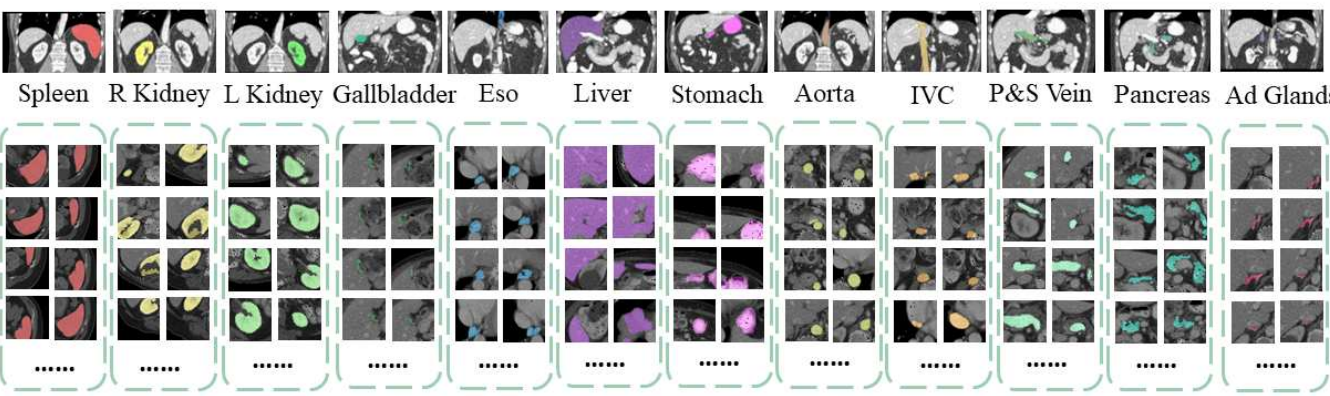

Figure: The above figure is taken from here https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589.

```
Modality: CT Size: 30 3D volumes (24 Training + 6 Testing)
Challenge: BTCV MICCAI Challenge
"labels":  {
    0: "background",
    1: "spleen",
    2: "right_kidney",
    3: "left_kidney",
    4: "gallbladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior_vena_cava",
    10: "portal_and_splenic_veins",
    11: "pancreas",
    12: "right_adrenal_gland",
    13: "left_adrenal_gland"
},
```

## Installation

```bash
pip install medicai
# or
pip install git+https://github.com/innat/medic-ai.git
```

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from medicai.utils.general import hide_warnings
hide_warnings()

import keras
from keras import ops
import tensorflow as tf

from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    CropForeground,
    RandCropByPosNegLabel,
    Spacing,
    Orientation,
    RandShiftIntensity,
    RandRotate90,
    RandFlip
)
from medicai.models import SwinUNETR
from medicai.metrics import SparseDiceMetric
from medicai.losses import SparseDiceCELoss
from medicai.utils.inference import SlidingWindowInference
from medicai.callbacks import SlidingWindowInferenceCallback

print(
    'keras backend: ', keras.config.backend(), '\n'
    'keras version: ', keras.version(), '\n'
    'tensorflow version: ', tf.__version__, '\n'
)

keras backend:  tensorflow 
keras version:  3.9.0 
tensorflow version:  2.19.0 



In [3]:
# reproducibility
keras.utils.set_random_seed(101)

# enable mixed precision
keras.config.set_dtype_policy("mixed_float16")

## Transformation

Each transformation expects the input to have the shape `(depth, height, width, channel)`. The original `.nii` (and converted `tfrecord`) format contains the input shape of `(height, width, depth)`. To make it compatible with `medicai`, we need to re-arrange the shape axes.

In [4]:
def rearrange_shape(sample):
    image = sample['image']
    label = sample['label']
    affine = sample['affine']

    # special case
    image = tf.transpose(image, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    label = tf.transpose(label, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    cols = tf.gather(affine, [2, 1, 0], axis=1)  # (whd) -> (dhw)
    affine = tf.concat([cols, affine[:, 3:]], axis=1)

    # re-update sample with new / updated tensor
    sample['image'] = image
    sample['label'] = label
    sample['affine'] = affine
    return sample

Each transformation class in medicai expects input as either a **dictionary** or a `TensorBundle` object. When a **dictionary** of input data (along with **metadata**) is passed, it is automatically wrapped into a `TensorBundle` instance. The examples below demonstrate how transformations are used in this way.



<div style="background-color: #d9edf7; padding: 20px; border-radius: 5px; border-left: 6px solid darkblue;">
  <h3 style="color: darkblue;">TensorBundle</h3>
  <p>
    The <strong>TensorBundle</strong> is a simple container for holding a dictionary of tensors and associated metadata. This class is designed to bundle together the actual data (tensors) and any relevant metadata (e.g., affine transformations, original shapes, spacing) related to that data. It provides convenient access and modification methods for both the data and the metadata.
  </p>
</div>

In [5]:
def train_transformation(sample):
    meta = {"affine": sample["affine"]}
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"]),
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
        RandCropByPosNegLabel(
            keys=("image", "label"),
            spatial_size=[96, 96, 96], 
            pos=1, 
            neg=1, 
            num_samples=1,
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.1),
        RandRotate90(keys=["image", "label"], prob=0.1, max_k=3, spatial_axes=(1, 2)),
        RandShiftIntensity(keys=["image"], offsets=0.10, prob=0.50),
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]


def val_transformation(sample):
    meta = {"affine": sample["affine"]} 
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"]),
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]


In [6]:
def parse_tfrecord_fn(example_proto):
    feature_description = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),
        "image_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),
        "image_affine": tf.io.FixedLenFeature([16], tf.float32),
        "label_affine": tf.io.FixedLenFeature([16], tf.float32),
        "image_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "label_pixdim": tf.io.FixedLenFeature([8], tf.float32),
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode image and label data
    image = tf.io.decode_raw(example["image_raw"], tf.float32)
    label = tf.io.decode_raw(example["label_raw"], tf.float32)
    
    # Reshape to original dimensions
    image = tf.reshape(image, example["image_shape"])
    label = tf.reshape(label, example["label_shape"])
    image = image[..., None] # hwd -> hwdc
    label = label[..., None] # hwd -> hwdc
    
    # Decode affine matrices
    image_affine = tf.squeeze(
        tf.reshape(example["image_affine"], (4, 4))
    )

    return {
        "image": image,
        "label": label,
        "affine": image_affine, # Since image and label affine are the same
    }

# Dataloader

In [7]:
def load_tfrecord_dataset(tfrecord_pattern, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_pattern))
    dataset = dataset.shuffle(buffer_size=50) if shuffle else dataset
    dataset = dataset.map(
        parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(
        rearrange_shape, num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        dataset = dataset.map(
            train_transformation, num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        dataset = dataset.map(
            val_transformation, num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
tfrecord_pattern = "/kaggle/input/abdomen/tfrecords/{}_shard_*.tfrec"

train_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("training"), batch_size=4, shuffle=True
)
val_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("validation"), batch_size=1, shuffle=False
)

I0000 00:00:1745597380.773726  884755 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


**sanity check**

In [9]:
x, y = next(iter(val_ds))
x.shape, y.shape

(TensorShape([1, 235, 214, 314, 1]), TensorShape([1, 235, 214, 314, 1]))

In [10]:
if len(x[0]) > 1:
    train_x, train_y = x[0], y[0]
else:
    train_x, train_y = x, y

train_x.shape, train_y.shape, np.unique(train_y)

(TensorShape([235, 214, 314, 1]),
 TensorShape([235, 214, 314, 1]),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       dtype=float32))

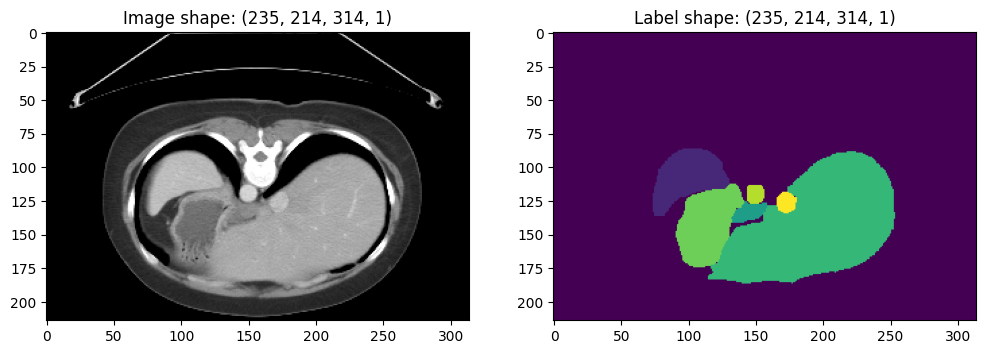

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(train_x[205], cmap='gray')
ax1.set_title(f'Image shape: {train_x.shape}')
ax2.imshow(train_y[205])
ax2.set_title(f'Label shape: {train_y.shape}')
plt.show()

# Model

We will be using the 3D model architecture [`SwinUNETR`](https://arxiv.org/abs/2201.01266). For BTCV, we will build the model with **1** input channels and **14** output channels.

In [9]:
epochs = 1500
num_classes=14
input_shape=(96, 96, 96, 1)

# build model
model = SwinUNETR(
    input_shape=input_shape,
    num_classes=num_classes,
    classifier_activation=None,
)

# compile
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
    ),
    loss=SparseDiceCELoss(
        from_logits=True, 
        num_classes=num_classes
    ),
    metrics=[
        SparseDiceMetric(
            from_logits=True,
            ignore_empty=True,
            num_classes=num_classes,
            name='dice',
        ),
    ],
)

model.output_shape

(None, 96, 96, 96, 14)

# Callback

We will be using sliding window inference callback to perform validation at certain interval or epoch during training. Based on the number of `epoch` size, set `interval` accordingly. For example, here `epoch` is set 1500 and we want to evaluate model on validation set every 50 epoch, then set `interval` to 50.

In [11]:
swi_callback_metric = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='val_dice'
)

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_ds, 
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=50,
    overlap=0.8,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    save_path="btcv.weights.h5",
    logging=True
)

In [ ]:
history = model.fit(
    train_ds, 
    epochs=1500,
    callbacks=[
        swi_callback
    ]
)

Epoch 1/1500


I0000 00:00:1745514976.226039 2164517 service.cc:152] XLA service 0x7f84740147b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745514976.226112 2164517 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745514988.667508 2164517 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745515236.972215 2164517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - dice: 0.0144 - loss: 4.6420 - swi_val_dice: 0.0000e+00
Epoch 2/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.0433 - loss: 3.8414 - swi_val_dice: 0.0000e+00
Epoch 3/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.0608 - loss: 3.4238 - swi_val_dice: 0.0000e+00
Epoch 4/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.0644 - loss: 3.0857 - swi_val_dice: 0.0000e+00
Epoch 5/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.0930 - loss: 2.8699 - swi_val_dice: 0.0000e+00
Epoch 6/1500
3/6 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - dice: 0.0904 - loss: 2.8029

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - dice: 0.0926 - loss: 2.7645 - swi_val_dice: 0.0000e+00
Epoch 7/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1052 - loss: 2.6126 - swi_val_dice: 0.0000e+00
Epoch 8/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1145 - loss: 2.5666 - swi_val_dice: 0.0000e+00
Epoch 9/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1189 - loss: 2.5053 - swi_val_dice: 0.0000e+00
Epoch 10/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1053 - loss: 2.4632 - swi_val_dice: 0.0000e+00
Epoch 11/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1178 - loss: 2.3627 - swi_val_dice: 0.0000e+00
Epoch 12/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1176 - loss: 2.3234 - swi_val_dice: 0.0000e+00
Epoch 13/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1112 - loss: 2.3406 - swi_val_dice: 0.0000e+00
Epoch 14/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1256 - loss: 2.2644 - swi_val_dice: 0.0000e+00
Epoch 15/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s

Total patch 840: 100%|██████████| 210/210 [03:00<00:00,  1.17it/s]


Epoch 50: Score = 0.1252
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1269s 251s/step - dice: 0.1172 - loss: 1.6612 - swi_val_dice: 0.1252
Epoch 51/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1378 - loss: 1.6586 - swi_val_dice: 0.0000e+00
Epoch 52/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1444 - loss: 1.6088 - swi_val_dice: 0.0000e+00
Epoch 53/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1475 - loss: 1.6133 - swi_val_dice: 0.0000e+00
Epoch 54/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1211 - loss: 1.6168 - swi_val_dice: 0.0000e+00
Epoch 55/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1155 - loss: 1.6487 - swi_val_dice: 0.0000e+00
Epoch 56/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1264 - loss: 1.6765 - swi_val_dice: 0.0000e+00
Epoch 57/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1471 - loss: 1.6068 - swi_val_dice: 0.0000e+00
Epoch 58/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1532 - loss: 1.63

Total patch 840: 100%|██████████| 210/210 [03:00<00:00,  1.16it/s]


Epoch 100: Score = 0.1294
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1242s 246s/step - dice: 0.1304 - loss: 1.3164 - swi_val_dice: 0.1294
Epoch 101/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1312 - loss: 1.4257 - swi_val_dice: 0.0000e+00
Epoch 102/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1558 - loss: 1.3534 - swi_val_dice: 0.0000e+00
Epoch 103/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1269 - loss: 1.3386 - swi_val_dice: 0.0000e+00
Epoch 104/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1725 - loss: 1.3901 - swi_val_dice: 0.0000e+00
Epoch 105/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1296 - loss: 1.3428 - swi_val_dice: 0.0000e+00
Epoch 106/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1714 - loss: 1.3577 - swi_val_dice: 0.0000e+00
Epoch 107/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1436 - loss: 1.3142 - swi_val_dice: 0.0000e+00
Epoch 108/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - dice: 0.1321 - l

Total patch 840: 100%|██████████| 210/210 [02:59<00:00,  1.17it/s]


Epoch 150: Score = 0.1355
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1227s 243s/step - dice: 0.2192 - loss: 1.2370 - swi_val_dice: 0.1355
Epoch 151/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1682 - loss: 1.2619 - swi_val_dice: 0.0000e+00
Epoch 152/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1636 - loss: 1.2733 - swi_val_dice: 0.0000e+00
Epoch 153/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.1767 - loss: 1.2304 - swi_val_dice: 0.0000e+00
Epoch 154/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.2560 - loss: 1.2002 - swi_val_dice: 0.0000e+00
Epoch 155/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1674 - loss: 1.2532 - swi_val_dice: 0.0000e+00
Epoch 156/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.1598 - loss: 1.2632 - swi_val_dice: 0.0000e+00
Epoch 157/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1473 - loss: 1.2610 - swi_val_dice: 0.0000e+00
Epoch 158/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2226 - l

Total patch 840: 100%|██████████| 210/210 [02:49<00:00,  1.24it/s]


Epoch 200: Score = 0.2249
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1171s 231s/step - dice: 0.2630 - loss: 1.1567 - swi_val_dice: 0.2249
Epoch 201/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2337 - loss: 1.1450 - swi_val_dice: 0.0000e+00
Epoch 202/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.3094 - loss: 1.1419 - swi_val_dice: 0.0000e+00
Epoch 203/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.1955 - loss: 1.1887 - swi_val_dice: 0.0000e+00
Epoch 204/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2408 - loss: 1.1497 - swi_val_dice: 0.0000e+00
Epoch 205/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2245 - loss: 1.1728 - swi_val_dice: 0.0000e+00
Epoch 206/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2352 - loss: 1.1649 - swi_val_dice: 0.0000e+00
Epoch 207/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.2277 - loss: 1.1605 - swi_val_dice: 0.0000e+00
Epoch 208/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2373 - l

Total patch 840: 100%|██████████| 210/210 [02:59<00:00,  1.17it/s]


Epoch 250: Score = 0.3166
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1239s 245s/step - dice: 0.3648 - loss: 1.0527 - swi_val_dice: 0.3166
Epoch 251/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.3387 - loss: 1.0587 - swi_val_dice: 0.0000e+00
Epoch 252/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2762 - loss: 1.0784 - swi_val_dice: 0.0000e+00
Epoch 253/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.3219 - loss: 1.0656 - swi_val_dice: 0.0000e+00
Epoch 254/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.3804 - loss: 1.0336 - swi_val_dice: 0.0000e+00
Epoch 255/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.3362 - loss: 1.0626 - swi_val_dice: 0.0000e+00
Epoch 256/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.3395 - loss: 1.0503 - swi_val_dice: 0.0000e+00
Epoch 257/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.3212 - loss: 1.0581 - swi_val_dice: 0.0000e+00
Epoch 258/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.3907 - l

Total patch 840: 100%|██████████| 210/210 [02:59<00:00,  1.17it/s]


Epoch 300: Score = 0.4298
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1245s 246s/step - dice: 0.4244 - loss: 1.0875 - swi_val_dice: 0.4298
Epoch 301/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.4647 - loss: 0.9991 - swi_val_dice: 0.0000e+00
Epoch 302/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4688 - loss: 1.0257 - swi_val_dice: 0.0000e+00
Epoch 303/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.4083 - loss: 1.0326 - swi_val_dice: 0.0000e+00
Epoch 304/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5167 - loss: 0.9874 - swi_val_dice: 0.0000e+00
Epoch 305/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.4941 - loss: 0.9888 - swi_val_dice: 0.0000e+00
Epoch 306/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4697 - loss: 0.9956 - swi_val_dice: 0.0000e+00
Epoch 307/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.2910 - loss: 1.2246 - swi_val_dice: 0.0000e+00
Epoch 308/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.4524 - l

Total patch 840: 100%|██████████| 210/210 [03:01<00:00,  1.15it/s]


Epoch 350: Score = 0.5135
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1282s 254s/step - dice: 0.4919 - loss: 0.9643 - swi_val_dice: 0.5135
Epoch 351/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.4892 - loss: 0.9743 - swi_val_dice: 0.0000e+00
Epoch 352/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4475 - loss: 1.0514 - swi_val_dice: 0.0000e+00
Epoch 353/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4778 - loss: 0.9709 - swi_val_dice: 0.0000e+00
Epoch 354/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4524 - loss: 0.9877 - swi_val_dice: 0.0000e+00
Epoch 355/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.4519 - loss: 1.0050 - swi_val_dice: 0.0000e+00
Epoch 356/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.4695 - loss: 0.9917 - swi_val_dice: 0.0000e+00
Epoch 357/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5454 - loss: 0.9202 - swi_val_dice: 0.0000e+00
Epoch 358/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.4698 - l

Total patch 840: 100%|██████████| 210/210 [02:59<00:00,  1.17it/s]


Epoch 400: Score = 0.5329
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1229s 243s/step - dice: 0.5683 - loss: 0.9288 - swi_val_dice: 0.5329
Epoch 401/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5116 - loss: 0.9691 - swi_val_dice: 0.0000e+00
Epoch 402/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - dice: 0.4924 - loss: 0.9413 - swi_val_dice: 0.0000e+00
Epoch 403/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5867 - loss: 0.9297 - swi_val_dice: 0.0000e+00
Epoch 404/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5057 - loss: 0.9823 - swi_val_dice: 0.0000e+00
Epoch 405/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5605 - loss: 0.9071 - swi_val_dice: 0.0000e+00
Epoch 406/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5283 - loss: 0.9462 - swi_val_dice: 0.0000e+00
Epoch 407/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5413 - loss: 1.0139 - swi_val_dice: 0.0000e+00
Epoch 408/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5138 - l

Total patch 840: 100%|██████████| 210/210 [02:58<00:00,  1.18it/s]


Epoch 450: Score = 0.6167
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1268s 251s/step - dice: 0.5397 - loss: 0.9181 - swi_val_dice: 0.6167
Epoch 451/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5954 - loss: 0.8828 - swi_val_dice: 0.0000e+00
Epoch 452/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.5797 - loss: 0.8527 - swi_val_dice: 0.0000e+00
Epoch 453/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6294 - loss: 0.8614 - swi_val_dice: 0.0000e+00
Epoch 454/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6462 - loss: 0.9048 - swi_val_dice: 0.0000e+00
Epoch 455/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6048 - loss: 0.8394 - swi_val_dice: 0.0000e+00
Epoch 456/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5994 - loss: 0.8534 - swi_val_dice: 0.0000e+00
Epoch 457/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5554 - loss: 0.9298 - swi_val_dice: 0.0000e+00
Epoch 458/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6050 - l

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 500: Score = 0.6129
6/6 ━━━━━━━━━━━━━━━━━━━━ 1188s 235s/step - dice: 0.5903 - loss: 0.8600 - swi_val_dice: 0.6129
Epoch 501/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6323 - loss: 0.8539 - swi_val_dice: 0.0000e+00
Epoch 502/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6046 - loss: 0.8711 - swi_val_dice: 0.0000e+00
Epoch 503/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.6388 - loss: 0.8376 - swi_val_dice: 0.0000e+00
Epoch 504/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6171 - loss: 0.8804 - swi_val_dice: 0.0000e+00
Epoch 505/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.5915 - loss: 0.8798 - swi_val_dice: 0.0000e+00
Epoch 506/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6204 - loss: 0.8638 - swi_val_dice: 0.0000e+00
Epoch 507/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6458 - loss: 0.8175 - swi_val_dice: 0.0000e+00
Epoch 508/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6031 - loss: 0.8845 - swi_val_dice: 0.0000e+00
Epoch 50

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 550: Score = 0.6293
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1201s 237s/step - dice: 0.6274 - loss: 0.8546 - swi_val_dice: 0.6293
Epoch 551/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6086 - loss: 0.8441 - swi_val_dice: 0.0000e+00
Epoch 552/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6463 - loss: 0.8431 - swi_val_dice: 0.0000e+00
Epoch 553/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6462 - loss: 0.7977 - swi_val_dice: 0.0000e+00
Epoch 554/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5625 - loss: 0.8718 - swi_val_dice: 0.0000e+00
Epoch 555/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6609 - loss: 0.8822 - swi_val_dice: 0.0000e+00
Epoch 556/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6570 - loss: 0.8168 - swi_val_dice: 0.0000e+00
Epoch 557/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6547 - loss: 0.8502 - swi_val_dice: 0.0000e+00
Epoch 558/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6569 - l

Total patch 840: 100%|██████████| 210/210 [03:00<00:00,  1.17it/s]


Epoch 600: Score = 0.6296
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1270s 252s/step - dice: 0.6055 - loss: 0.8620 - swi_val_dice: 0.6296
Epoch 601/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6308 - loss: 0.8078 - swi_val_dice: 0.0000e+00
Epoch 602/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6470 - loss: 0.8425 - swi_val_dice: 0.0000e+00
Epoch 603/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6284 - loss: 0.8209 - swi_val_dice: 0.0000e+00
Epoch 604/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.6243 - loss: 0.8404 - swi_val_dice: 0.0000e+00
Epoch 605/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.5907 - loss: 0.8771 - swi_val_dice: 0.0000e+00
Epoch 606/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6041 - loss: 0.8764 - swi_val_dice: 0.0000e+00
Epoch 607/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6048 - loss: 0.8617 - swi_val_dice: 0.0000e+00
Epoch 608/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6174 - l

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 650: Score = 0.6474
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1229s 243s/step - dice: 0.6655 - loss: 0.8087 - swi_val_dice: 0.6474
Epoch 651/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6520 - loss: 0.8312 - swi_val_dice: 0.0000e+00
Epoch 652/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6638 - loss: 0.8274 - swi_val_dice: 0.0000e+00
Epoch 653/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6501 - loss: 0.8139 - swi_val_dice: 0.0000e+00
Epoch 654/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6532 - loss: 0.8424 - swi_val_dice: 0.0000e+00
Epoch 655/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6557 - loss: 0.7980 - swi_val_dice: 0.0000e+00
Epoch 656/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6715 - loss: 0.8226 - swi_val_dice: 0.0000e+00
Epoch 657/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6839 - loss: 0.7620 - swi_val_dice: 0.0000e+00
Epoch 658/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6805 - l

Total patch 840: 100%|██████████| 210/210 [02:51<00:00,  1.23it/s]


Epoch 700: Score = 0.6600
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1223s 242s/step - dice: 0.7140 - loss: 0.8123 - swi_val_dice: 0.6600
Epoch 701/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6410 - loss: 0.8665 - swi_val_dice: 0.0000e+00
Epoch 702/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7024 - loss: 0.7845 - swi_val_dice: 0.0000e+00
Epoch 703/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7164 - loss: 0.7552 - swi_val_dice: 0.0000e+00
Epoch 704/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6871 - loss: 0.8227 - swi_val_dice: 0.0000e+00
Epoch 705/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6538 - loss: 0.8654 - swi_val_dice: 0.0000e+00
Epoch 706/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6957 - loss: 0.7784 - swi_val_dice: 0.0000e+00
Epoch 707/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6722 - loss: 0.8257 - swi_val_dice: 0.0000e+00
Epoch 708/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7012 - l

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 750: Score = 0.6888
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1217s 241s/step - dice: 0.6735 - loss: 0.7732 - swi_val_dice: 0.6888
Epoch 751/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.6778 - loss: 0.8394 - swi_val_dice: 0.0000e+00
Epoch 752/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - dice: 0.6838 - loss: 0.7488 - swi_val_dice: 0.0000e+00
Epoch 753/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7173 - loss: 0.7985 - swi_val_dice: 0.0000e+00
Epoch 754/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7361 - loss: 0.7930 - swi_val_dice: 0.0000e+00
Epoch 755/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6929 - loss: 0.7744 - swi_val_dice: 0.0000e+00
Epoch 756/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7157 - loss: 0.8341 - swi_val_dice: 0.0000e+00
Epoch 757/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7308 - loss: 0.7736 - swi_val_dice: 0.0000e+00
Epoch 758/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7121 - l

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 800: Score = 0.6768
6/6 ━━━━━━━━━━━━━━━━━━━━ 1211s 240s/step - dice: 0.7039 - loss: 0.7509 - swi_val_dice: 0.6768
Epoch 801/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.6776 - loss: 0.8094 - swi_val_dice: 0.0000e+00
Epoch 802/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7465 - loss: 0.8196 - swi_val_dice: 0.0000e+00
Epoch 803/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7172 - loss: 0.8202 - swi_val_dice: 0.0000e+00
Epoch 804/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.6871 - loss: 0.7716 - swi_val_dice: 0.0000e+00
Epoch 805/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7207 - loss: 0.7929 - swi_val_dice: 0.0000e+00
Epoch 806/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - dice: 0.7407 - loss: 0.7672 - swi_val_dice: 0.0000e+00
Epoch 807/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7326 - loss: 0.7379 - swi_val_dice: 0.0000e+00
Epoch 808/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7150 - loss: 0.7882 - swi_val_dice: 0.0000e+00
Epoch 80

Total patch 840: 100%|██████████| 210/210 [02:51<00:00,  1.23it/s]


Epoch 850: Score = 0.7116
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1209s 239s/step - dice: 0.7640 - loss: 0.7569 - swi_val_dice: 0.7116
Epoch 851/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7400 - loss: 0.7616 - swi_val_dice: 0.0000e+00
Epoch 852/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7364 - loss: 0.7960 - swi_val_dice: 0.0000e+00
Epoch 853/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7549 - loss: 0.7244 - swi_val_dice: 0.0000e+00
Epoch 854/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7241 - loss: 0.8736 - swi_val_dice: 0.0000e+00
Epoch 855/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7631 - loss: 0.7434 - swi_val_dice: 0.0000e+00
Epoch 856/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7533 - loss: 0.7621 - swi_val_dice: 0.0000e+00
Epoch 857/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7129 - loss: 0.8007 - swi_val_dice: 0.0000e+00
Epoch 858/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - dice: 0.7278 - l

Total patch 840: 100%|██████████| 210/210 [03:04<00:00,  1.14it/s]


Epoch 900: Score = 0.7371
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1275s 253s/step - dice: 0.7263 - loss: 0.8087 - swi_val_dice: 0.7371
Epoch 901/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7748 - loss: 0.7274 - swi_val_dice: 0.0000e+00
Epoch 902/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7346 - loss: 0.8120 - swi_val_dice: 0.0000e+00
Epoch 903/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7721 - loss: 0.7957 - swi_val_dice: 0.0000e+00
Epoch 904/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7513 - loss: 0.7520 - swi_val_dice: 0.0000e+00
Epoch 905/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7673 - loss: 0.7368 - swi_val_dice: 0.0000e+00
Epoch 906/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7879 - loss: 0.7493 - swi_val_dice: 0.0000e+00
Epoch 907/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7826 - loss: 0.7768 - swi_val_dice: 0.0000e+00
Epoch 908/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7020 - l

Total patch 840: 100%|██████████| 210/210 [03:02<00:00,  1.15it/s]


Epoch 950: Score = 0.7276
6/6 ━━━━━━━━━━━━━━━━━━━━ 1280s 253s/step - dice: 0.7734 - loss: 0.7837 - swi_val_dice: 0.7276
Epoch 951/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7652 - loss: 0.7347 - swi_val_dice: 0.0000e+00
Epoch 952/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7726 - loss: 0.7383 - swi_val_dice: 0.0000e+00
Epoch 953/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7819 - loss: 0.7113 - swi_val_dice: 0.0000e+00
Epoch 954/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7842 - loss: 0.7184 - swi_val_dice: 0.0000e+00
Epoch 955/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7894 - loss: 0.7331 - swi_val_dice: 0.0000e+00
Epoch 956/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7440 - loss: 0.7538 - swi_val_dice: 0.0000e+00
Epoch 957/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7861 - loss: 0.7392 - swi_val_dice: 0.0000e+00
Epoch 958/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7599 - loss: 0.7831 - swi_val_dice: 0.0000e+00
Epoch 95

Total patch 840: 100%|██████████| 210/210 [02:58<00:00,  1.18it/s]


Epoch 1000: Score = 0.7791
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1229s 243s/step - dice: 0.8224 - loss: 0.7939 - swi_val_dice: 0.7791
Epoch 1001/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8436 - loss: 0.7591 - swi_val_dice: 0.0000e+00
Epoch 1002/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7915 - loss: 0.7674 - swi_val_dice: 0.0000e+00
Epoch 1003/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8311 - loss: 0.8186 - swi_val_dice: 0.0000e+00
Epoch 1004/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8371 - loss: 0.6998 - swi_val_dice: 0.0000e+00
Epoch 1005/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8298 - loss: 0.6932 - swi_val_dice: 0.0000e+00
Epoch 1006/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7035 - loss: 0.8398 - swi_val_dice: 0.0000e+00
Epoch 1007/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8179 - loss: 0.7558 - swi_val_dice: 0.0000e+00
Epoch 1008/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0

Total patch 840: 100%|██████████| 210/210 [02:48<00:00,  1.25it/s]


Epoch 1050: Score = 0.7714
6/6 ━━━━━━━━━━━━━━━━━━━━ 1197s 237s/step - dice: 0.7564 - loss: 0.7531 - swi_val_dice: 0.7714
Epoch 1051/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8377 - loss: 0.6971 - swi_val_dice: 0.0000e+00
Epoch 1052/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7984 - loss: 0.7508 - swi_val_dice: 0.0000e+00
Epoch 1053/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.7957 - loss: 0.7305 - swi_val_dice: 0.0000e+00
Epoch 1054/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8052 - loss: 0.7630 - swi_val_dice: 0.0000e+00
Epoch 1055/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8183 - loss: 0.7176 - swi_val_dice: 0.0000e+00
Epoch 1056/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8298 - loss: 0.7675 - swi_val_dice: 0.0000e+00
Epoch 1057/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8232 - loss: 0.7316 - swi_val_dice: 0.0000e+00
Epoch 1058/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8416 - loss: 0.7437 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:47<00:00,  1.25it/s]


Epoch 1100: Score = 0.7741
6/6 ━━━━━━━━━━━━━━━━━━━━ 1177s 233s/step - dice: 0.8280 - loss: 0.6990 - swi_val_dice: 0.7741
Epoch 1101/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7804 - loss: 0.7501 - swi_val_dice: 0.0000e+00
Epoch 1102/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8338 - loss: 0.7381 - swi_val_dice: 0.0000e+00
Epoch 1103/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8461 - loss: 0.6949 - swi_val_dice: 0.0000e+00
Epoch 1104/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8135 - loss: 0.7592 - swi_val_dice: 0.0000e+00
Epoch 1105/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice: 0.8154 - loss: 0.6982 - swi_val_dice: 0.0000e+00
Epoch 1106/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8490 - loss: 0.6709 - swi_val_dice: 0.0000e+00
Epoch 1107/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8364 - loss: 0.6543 - swi_val_dice: 0.0000e+00
Epoch 1108/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8292 - loss: 0.7373 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:45<00:00,  1.27it/s]


Epoch 1150: Score = 0.7898
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1172s 232s/step - dice: 0.8198 - loss: 0.7279 - swi_val_dice: 0.7898
Epoch 1151/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice: 0.8416 - loss: 0.7389 - swi_val_dice: 0.0000e+00
Epoch 1152/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8340 - loss: 0.7378 - swi_val_dice: 0.0000e+00
Epoch 1153/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8250 - loss: 0.6874 - swi_val_dice: 0.0000e+00
Epoch 1154/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8252 - loss: 0.6740 - swi_val_dice: 0.0000e+00
Epoch 1155/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8313 - loss: 0.7231 - swi_val_dice: 0.0000e+00
Epoch 1156/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8385 - loss: 0.7016 - swi_val_dice: 0.0000e+00
Epoch 1157/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8204 - loss: 0.6749 - swi_val_dice: 0.0000e+00
Epoch 1158/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice: 0

Total patch 840: 100%|██████████| 210/210 [02:45<00:00,  1.27it/s]


Epoch 1200: Score = 0.7990
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1177s 233s/step - dice: 0.8573 - loss: 0.7179 - swi_val_dice: 0.7990
Epoch 1201/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8653 - loss: 0.6880 - swi_val_dice: 0.0000e+00
Epoch 1202/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8659 - loss: 0.6365 - swi_val_dice: 0.0000e+00
Epoch 1203/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7944 - loss: 0.7122 - swi_val_dice: 0.0000e+00
Epoch 1204/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8516 - loss: 0.6739 - swi_val_dice: 0.0000e+00
Epoch 1205/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8439 - loss: 0.6853 - swi_val_dice: 0.0000e+00
Epoch 1206/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8697 - loss: 0.7020 - swi_val_dice: 0.0000e+00
Epoch 1207/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7905 - loss: 0.7246 - swi_val_dice: 0.0000e+00
Epoch 1208/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0

Total patch 840: 100%|██████████| 210/210 [02:45<00:00,  1.27it/s]


Epoch 1250: Score = 0.7749
6/6 ━━━━━━━━━━━━━━━━━━━━ 1163s 230s/step - dice: 0.8461 - loss: 0.6492 - swi_val_dice: 0.7749
Epoch 1251/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8587 - loss: 0.6872 - swi_val_dice: 0.0000e+00
Epoch 1252/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8161 - loss: 0.7127 - swi_val_dice: 0.0000e+00
Epoch 1253/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8255 - loss: 0.7038 - swi_val_dice: 0.0000e+00
Epoch 1254/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8104 - loss: 0.7632 - swi_val_dice: 0.0000e+00
Epoch 1255/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8473 - loss: 0.7142 - swi_val_dice: 0.0000e+00
Epoch 1256/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8075 - loss: 0.7504 - swi_val_dice: 0.0000e+00
Epoch 1257/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8420 - loss: 0.7461 - swi_val_dice: 0.0000e+00
Epoch 1258/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8324 - loss: 0.7170 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:52<00:00,  1.21it/s]


Epoch 1300: Score = 0.8003
New best score! Model saved to btcv.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1177s 233s/step - dice: 0.8377 - loss: 0.7841 - swi_val_dice: 0.8003
Epoch 1301/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7902 - loss: 0.8253 - swi_val_dice: 0.0000e+00
Epoch 1302/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.7974 - loss: 0.7725 - swi_val_dice: 0.0000e+00
Epoch 1303/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8408 - loss: 0.6940 - swi_val_dice: 0.0000e+00
Epoch 1304/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8396 - loss: 0.7140 - swi_val_dice: 0.0000e+00
Epoch 1305/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.7801 - loss: 0.7594 - swi_val_dice: 0.0000e+00
Epoch 1306/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8582 - loss: 0.7415 - swi_val_dice: 0.0000e+00
Epoch 1307/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8477 - loss: 0.7652 - swi_val_dice: 0.0000e+00
Epoch 1308/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0

Total patch 840: 100%|██████████| 210/210 [02:46<00:00,  1.26it/s]


Epoch 1350: Score = 0.7787
6/6 ━━━━━━━━━━━━━━━━━━━━ 1185s 234s/step - dice: 0.8402 - loss: 0.7579 - swi_val_dice: 0.7787
Epoch 1351/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8170 - loss: 0.7105 - swi_val_dice: 0.0000e+00
Epoch 1352/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8533 - loss: 0.7590 - swi_val_dice: 0.0000e+00
Epoch 1353/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8300 - loss: 0.7582 - swi_val_dice: 0.0000e+00
Epoch 1354/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8356 - loss: 0.7169 - swi_val_dice: 0.0000e+00
Epoch 1355/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8531 - loss: 0.7250 - swi_val_dice: 0.0000e+00
Epoch 1356/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8126 - loss: 0.7453 - swi_val_dice: 0.0000e+00
Epoch 1357/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8382 - loss: 0.7017 - swi_val_dice: 0.0000e+00
Epoch 1358/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8723 - loss: 0.7469 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 1400: Score = 0.7888
6/6 ━━━━━━━━━━━━━━━━━━━━ 1207s 239s/step - dice: 0.8388 - loss: 0.7160 - swi_val_dice: 0.7888
Epoch 1401/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8248 - loss: 0.6973 - swi_val_dice: 0.0000e+00
Epoch 1402/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8511 - loss: 0.7423 - swi_val_dice: 0.0000e+00
Epoch 1403/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - dice: 0.8240 - loss: 0.6719 - swi_val_dice: 0.0000e+00
Epoch 1404/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8737 - loss: 0.7526 - swi_val_dice: 0.0000e+00
Epoch 1405/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8643 - loss: 0.7461 - swi_val_dice: 0.0000e+00
Epoch 1406/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8565 - loss: 0.6714 - swi_val_dice: 0.0000e+00
Epoch 1407/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8585 - loss: 0.6992 - swi_val_dice: 0.0000e+00
Epoch 1408/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8384 - loss: 0.7152 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:49<00:00,  1.24it/s]


Epoch 1450: Score = 0.7875
6/6 ━━━━━━━━━━━━━━━━━━━━ 1169s 231s/step - dice: 0.8685 - loss: 0.6206 - swi_val_dice: 0.7875
Epoch 1451/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8636 - loss: 0.6397 - swi_val_dice: 0.0000e+00
Epoch 1452/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8495 - loss: 0.6956 - swi_val_dice: 0.0000e+00
Epoch 1453/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8726 - loss: 0.6505 - swi_val_dice: 0.0000e+00
Epoch 1454/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8443 - loss: 0.6918 - swi_val_dice: 0.0000e+00
Epoch 1455/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8683 - loss: 0.6566 - swi_val_dice: 0.0000e+00
Epoch 1456/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - dice: 0.8678 - loss: 0.6697 - swi_val_dice: 0.0000e+00
Epoch 1457/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - dice: 0.8280 - loss: 0.7240 - swi_val_dice: 0.0000e+00
Epoch 1458/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice: 0.8692 - loss: 0.6904 - swi_val_dice: 0.0000e+00

Total patch 840: 100%|██████████| 210/210 [02:48<00:00,  1.25it/s]


Epoch 1500: Score = 0.7845
6/6 ━━━━━━━━━━━━━━━━━━━━ 1189s 235s/step - dice: 0.8461 - loss: 0.6976 - swi_val_dice: 0.7845


In [17]:
print(model.history.history.keys())
his_csv = pd.DataFrame(model.history.history)
his_csv.to_csv('btcv.history.csv')
his_csv.head()

dict_keys(['dice', 'loss', 'swi_val_dice'])


,dice,loss,swi_val_dice
0,0.018280,4.454813,0.0
1,0.047543,3.760464,0.0
2,0.060096,3.340100,0.0
3,0.065242,3.038510,0.0
4,0.090193,2.846872,0.0


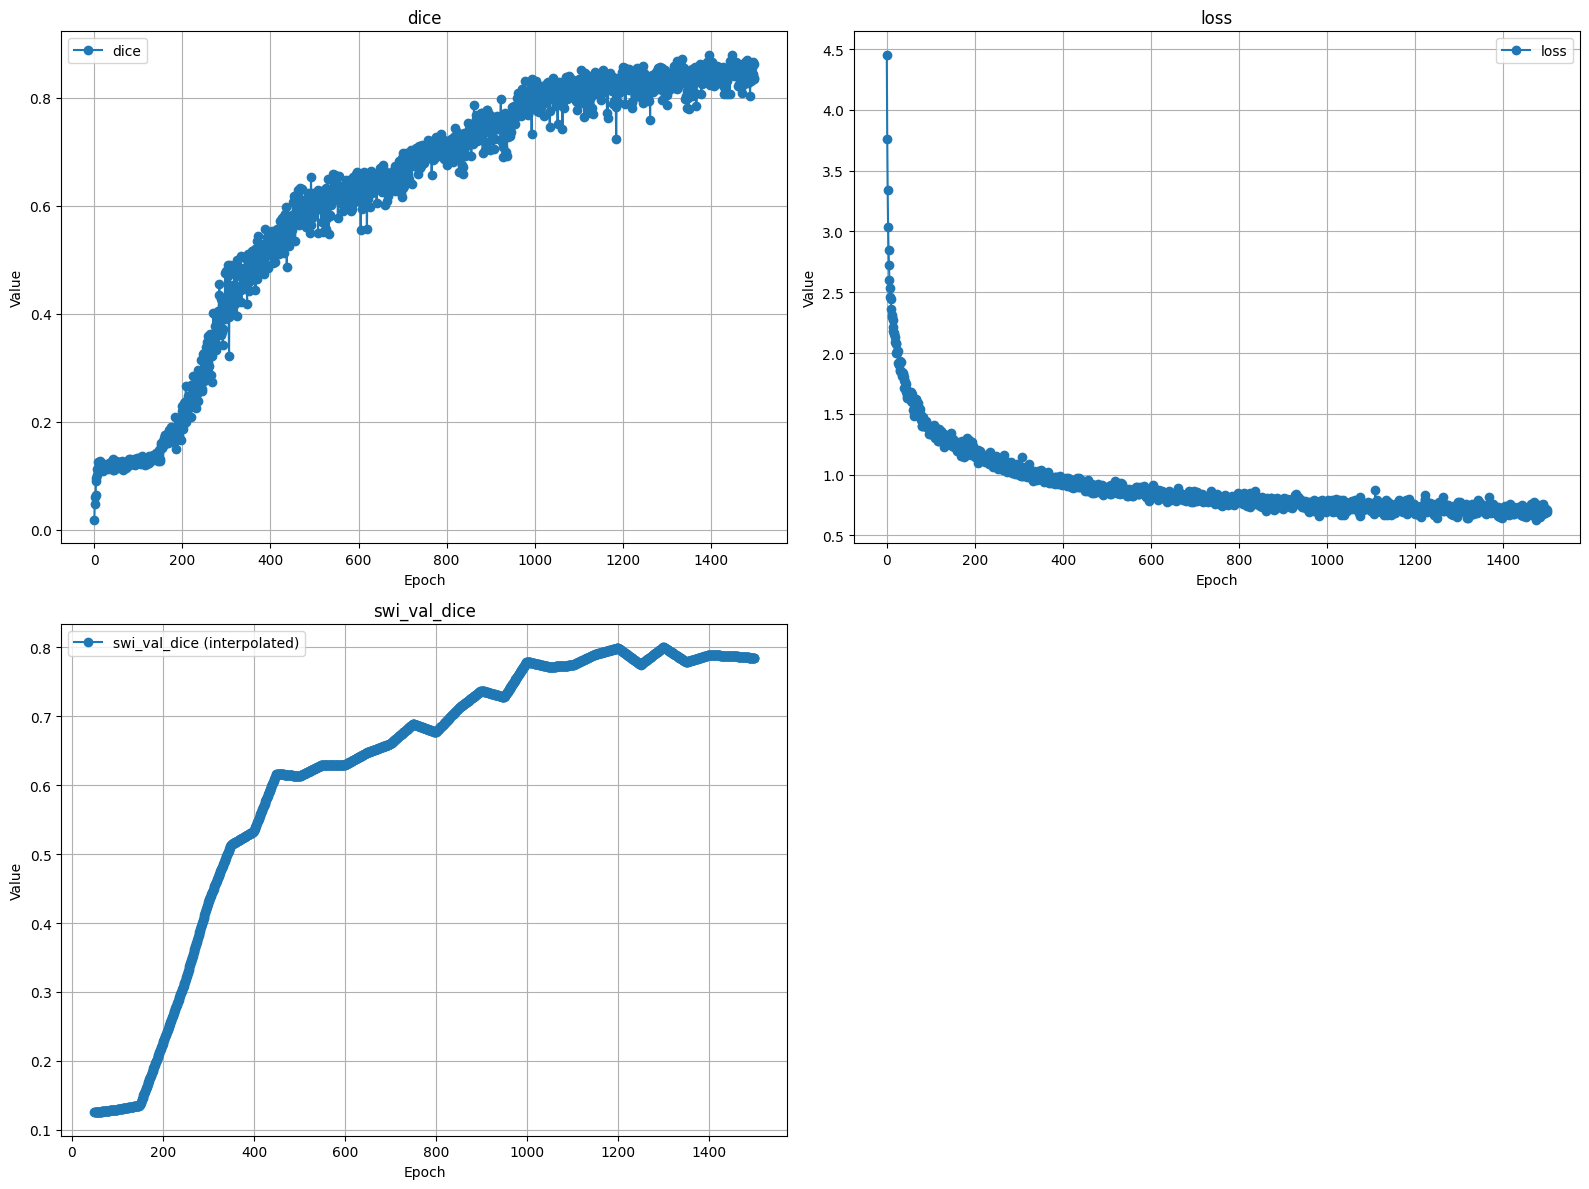

In [28]:
def plot_training_history(history_df):
    metrics = history_df.columns
    n_metrics = len(metrics)
    
    n_rows = 2
    n_cols = (n_metrics + 1) // 2 

    plt.figure(figsize=(8 * n_cols, 6 * n_rows))

    for idx, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, idx + 1)
        
        if metric == 'swi_val_dice':
            # Replace zeros with NaN except for actual values at intervals
            val_dice = history_df[metric].copy()
            mask = val_dice != 0
            val_dice_interp = val_dice.replace(0, np.nan).interpolate(method='linear')
            plt.plot(val_dice_interp, label=f'{metric} (interpolated)', marker='o')
        else:
            plt.plot(history_df[metric], label=metric, marker='o')

        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(his_csv)

# Evaluation

We can evaluate the model per-class or on average.

In [47]:
label_map = {
    0: "background",
    1: "spleen",
    2: "right_kidneys",
    3: "left_kidneys",
    4: "gallbladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "Inferior vena cava (IVC)",
    10: "veins",
    11: "pancreas",
    12: "Right adrenal gland",
    13: "Left adrenal gland"
}

In [30]:
model.load_weights(
    "btcv.weights.h5"
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.8,
)

In [39]:
dice = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice_all'
)
dice_kidneys = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[2,3],
    num_classes=num_classes,
    name='dice_kidneys'
)
dice_esophagus = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[5],
    num_classes=num_classes,
    name='dice_esophagus'
)
dice_pancreas = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[11],
    num_classes=num_classes,
    name='dice_pancreas'
)

In [41]:
for sample in val_ds:
    x, y = sample
    output = swi(x)
    
    y = ops.convert_to_tensor(y)
    output = ops.convert_to_tensor(output)
    
    dice.update_state(y, output)
    dice_kidneys.update_state(y, output)
    dice_esophagus.update_state(y, output)
    dice_pancreas.update_state(y, output)

dice_score = float(ops.convert_to_numpy(dice.result()))
dice_score_kidneys = float(ops.convert_to_numpy(dice_kidneys.result()))
dice_score_esophagus = float(ops.convert_to_numpy(dice_esophagus.result()))
dice_score_pancreas = float(ops.convert_to_numpy(dice_pancreas.result()))

print(f"Dice Score: {dice_score:.4f}")
print(f"Dice Score on Kidneys: {dice_score_kidneys:.4f}")
print(f"Dice Score on Esophagus: {dice_score_esophagus:.4f}")
print(f"Dice Score on Pancreas: {dice_score_pancreas:.4f}")

dice.reset_state()
dice_kidneys.reset_state()
dice_esophagus.reset_state()
dice_pancreas.reset_state()

Total patch 120: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Dice Score: 0.7832
Dice Score on Kidneys: 0.8815
Dice Score on Esophagus: 0.7012
Dice Score on Pancreas: 0.7214


# Analyse and Visualize

In [42]:
model.load_weights(
    'btcv.weights.h5'
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.8,
)

In [44]:
x, y = next(iter(val_ds))
x, y = x.numpy(), y.numpy()
x.shape, y.shape, np.unique(y)

((1, 235, 214, 314, 1),
 (1, 235, 214, 314, 1),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       dtype=float32))

In [45]:
y_pred = swi(x)
y_pred = y_pred.argmax(-1)
y_pred.shape

Total patch 936: 100%|██████████| 234/234 [03:16<00:00,  1.19it/s]


(1, 235, 214, 314)

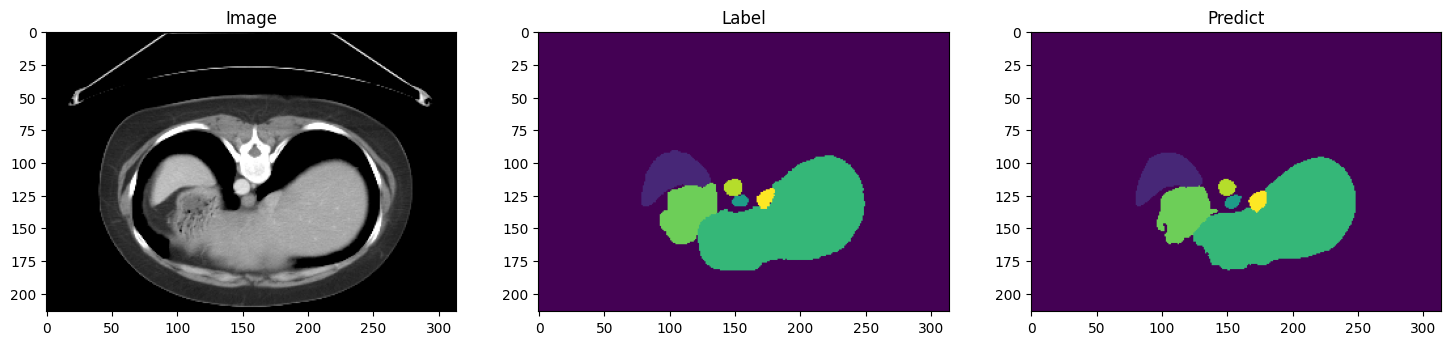

In [59]:
slice_num=210
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(x[0, slice_num, :, :, 0], cmap="gray")
ax1.set_title('Image')
ax2.imshow(y[0, slice_num, :, :, 0])
ax2.set_title('Label')
ax3.imshow(y_pred[0, slice_num, :, :])
ax3.set_title('Predict')
plt.show()